# Machine Learning Intro – Exercise Notebook

This notebook accompanies the *Start‑up Seminar* (2025‑06‑04).  
Work through the problems to reinforce the ideas from the lecture:
1. End‑to‑end regression workflow with the California‑housing data
2. End‑to‑end classification workflow with the Breast‑Cancer data
3. End‑to‑end clustering analysis with the Iris data (incl. PCA visualization)

You’ll need ~2 h if you code along diligently. Good luck!

## 0.  Environment setup
Run the cell below to import common libraries. Feel free to add any others you need.

In [90]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
from sklearn.datasets import fetch_california_housing, load_breast_cancer, load_iris
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

set_config(transform_output='pandas')  # nicer display
np.random.seed(42)

## 1.  Regression – California Housing
**Dataset**  

The California Housing dataset is a classic dataset from the 1990s used for regression tasks. It contains information on housing prices in California districts and is often used to predict median house value based on various features.

Key Characteristics:

- Target: Median house value (in $100,000s)

- Features (8 total):

    - `MedInc`: Median income in the district

    - `HouseAge`: Median house age

    - `AveRooms`: Average number of rooms per household

    - `AveBedrms`: Average number of bedrooms

    - `Population`: Total population

    - `AveOccup`: Average number of household members

    - `Latitude`: Latitude of the district

    - `Longitude`: Longitude of the district

**Hands-on Workout**  

We will build a model to predict **median house value**.
The section mirrors the project workflow you saw in the slides:
- data acquisition & EDA
- preprocessing (train/test split, scaling, …)
- baseline model → evaluation (RMSE, MAE)
- more powerful model → hyper‑parameter tuning


### 1.1  Load the dataset

In [5]:
# ----- TODO: load the California‑housing dataset into a DataFrame `df_reg` ----- #

# Load the Dataset
data = fetch_california_housing(as_frame=True)
df_reg = data.frame
display(df_reg.head())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### 1.2  Train/test split
- Create `X_train`, `X_test`, `y_train`, `y_test` using an 80/20 split.
- Create `df_train` by concatenating `X_train` and `y_train`

In [17]:
# ----- TODO: split the data ----- #

# Split the data into training and testing sets
X = df_reg.drop('MedHouseVal', axis=1)
y = df_reg['MedHouseVal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the split
print(f"Training features set size: {X_train.shape}")
print(f"Testing features set size: {X_test.shape}")
print(f"Training target set size: {y_train.shape}")
print(f"Testing target set size: {y_test.shape}")

Training features set size: (16512, 8)
Testing features set size: (4128, 8)
Training target set size: (16512,)
Testing target set size: (4128,)


In [97]:
# ----- TODO: create df_train ----- #

# Create Train DataFrame
df_train = pd.concat([X_train, y_train], axis=1)
df_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
68,9.029,17.33,58.79,250.5,0.10660,0.14130,0.31300,0.04375,0.2111,0.08046,...,22.65,65.50,324.7,0.14820,0.43650,1.25200,0.17500,0.4228,0.11750,1
181,21.090,26.57,142.70,1311.0,0.11410,0.28320,0.24870,0.14960,0.2395,0.07398,...,33.48,176.50,2089.0,0.14910,0.75840,0.67800,0.29030,0.4098,0.12840,0
63,9.173,13.86,59.20,260.9,0.07721,0.08751,0.05988,0.02180,0.2341,0.06963,...,19.23,65.59,310.1,0.09836,0.16780,0.13970,0.05087,0.3282,0.08490,1
248,10.650,25.22,68.01,347.0,0.09657,0.07234,0.02379,0.01615,0.1897,0.06329,...,35.19,77.98,455.7,0.14990,0.13980,0.11250,0.06136,0.3409,0.08147,1
60,10.170,14.88,64.55,311.9,0.11340,0.08061,0.01084,0.01290,0.2743,0.06960,...,17.45,69.86,368.6,0.12750,0.09866,0.02168,0.02579,0.3557,0.08020,1


### 1.3  Exploratory Data Analysis (EDA)
- Show basic `.info()` / `.describe()`
- Visualise one numerical feature distribution (e.g., histogram)
- Plot a pairwise scatter matrix or correlation heat‑map

In [44]:
# ----- TODO: your EDA code here ----- #

# Show basic .info() / .describe()
print("Basic Info:")
display(df_train.info())
print("\nBasic Description:")
display(df_train.describe())

Basic Info:
<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 14196 to 15795
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       16512 non-null  float64
 1   HouseAge     16512 non-null  float64
 2   AveRooms     16512 non-null  float64
 3   AveBedrms    16512 non-null  float64
 4   Population   16512 non-null  float64
 5   AveOccup     16512 non-null  float64
 6   Latitude     16512 non-null  float64
 7   Longitude    16512 non-null  float64
 8   MedHouseVal  16512 non-null  float64
dtypes: float64(9)
memory usage: 1.3 MB


None


Basic Description:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,3.880754,28.608285,5.435235,1.096685,1426.453004,3.096961,35.643149,-119.582290,2.071947
std,1.904294,12.602499,2.387375,0.433215,1137.056380,11.578744,2.136665,2.005654,1.156226
min,0.499900,1.000000,0.888889,0.333333,3.000000,0.692308,32.550000,-124.350000,0.149990
25%,2.566700,18.000000,4.452055,1.006508,789.000000,2.428799,33.930000,-121.810000,1.198000
50%,3.545800,29.000000,5.235874,1.049286,1167.000000,2.817240,34.260000,-118.510000,1.798500
75%,4.773175,37.000000,6.061037,1.100348,1726.000000,3.280000,37.720000,-118.010000,2.651250
max,15.000100,52.000000,141.909091,25.636364,35682.000000,1243.333333,41.950000,-114.310000,5.000010


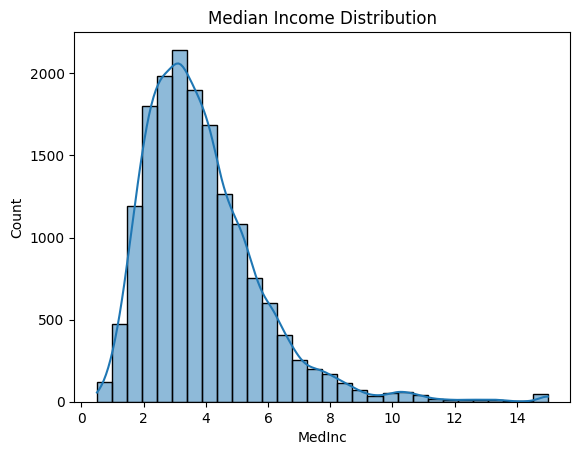

In [45]:
# Visualise one numerical feature distribution
sns.histplot(df_train['MedInc'], bins=30, kde=True)
plt.title("Median Income Distribution")
plt.show()

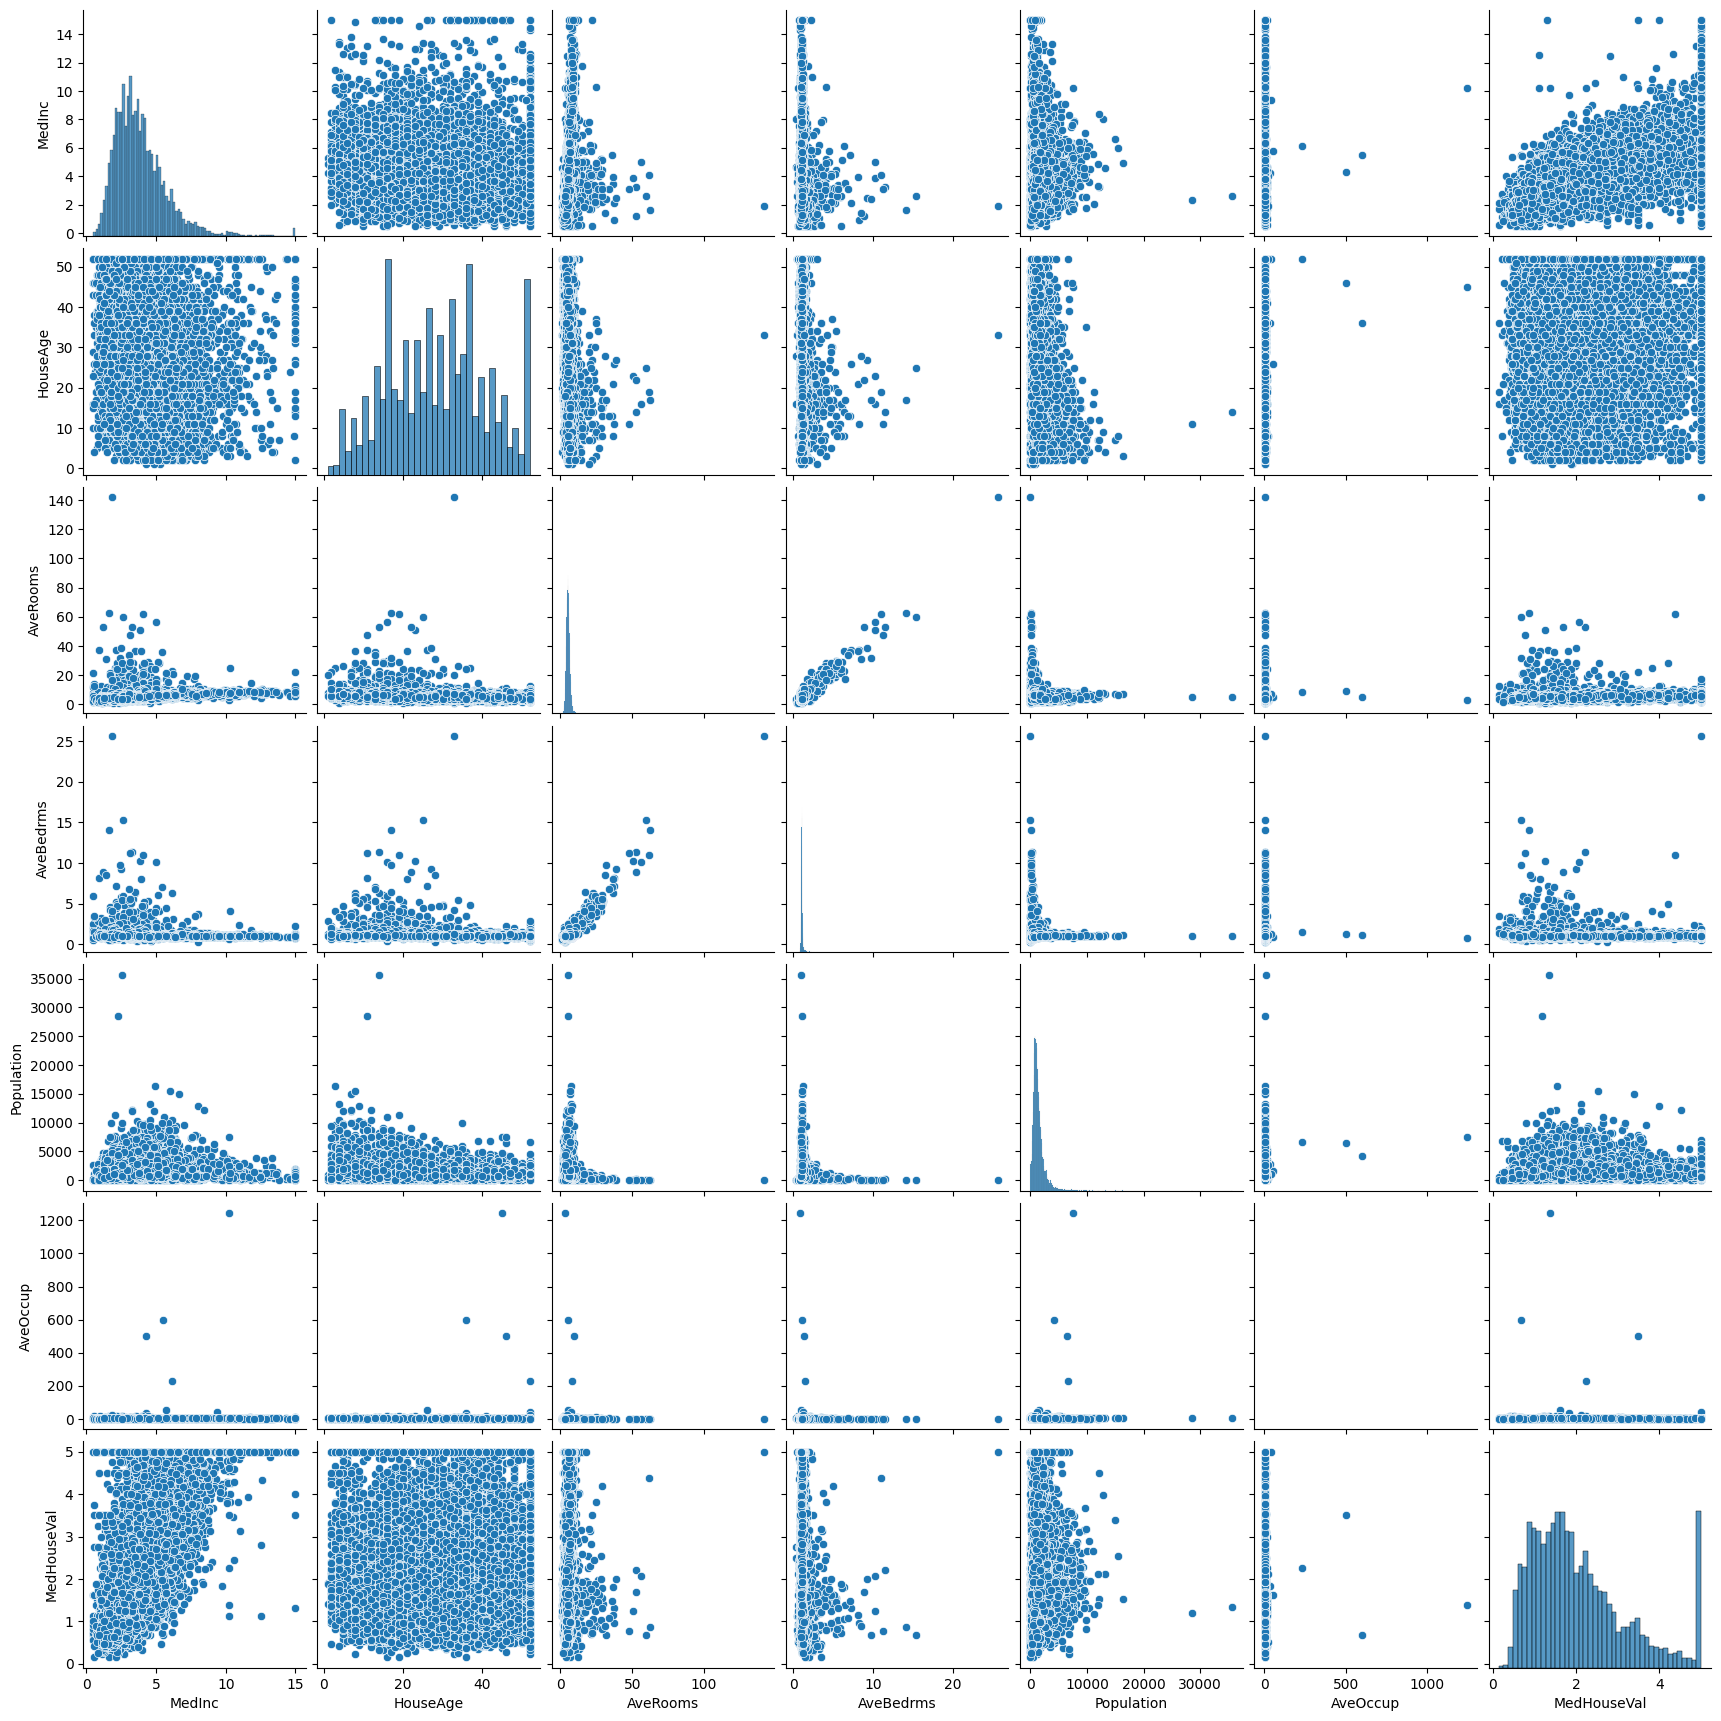

In [46]:
# Plot a pairwise scatter matrix
sns.pairplot(df_train[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'MedHouseVal']])
plt.show()

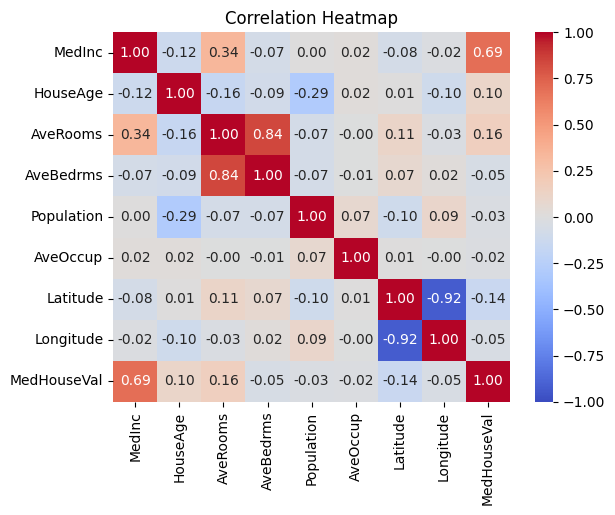

In [47]:
# Plot a correlation heatmap
corr_matrix = df_train.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### 1.4  Pre‑processing pipeline
Build a `scikit‑learn` pipeline that (optionally) scales features with `StandardScaler` and fits a **LinearRegression** model as a baseline.

In [20]:
# ----- TODO: build and fit the baseline pipeline ----- #

# Build and fit the baseline pipeline
baseline_pipeline = make_pipeline(StandardScaler(), LinearRegression())
baseline_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

### 1.5  Evaluate the baseline
Compute **RMSE** and **MAE** on the test set.

In [25]:
# ----- TODO: evaluate baseline ----- #

# Evaluate the baseline pipeline
y_pred = baseline_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Baseline RMSE: {rmse:.2f}")
print(f"Baseline MAE: {mae:.2f}")

Baseline RMSE: 0.75
Baseline MAE: 0.53


### 1.6  Decision‑Tree Regressor
- Fit a `DecisionTreeRegressor`
- Evaluate the metrics again
- Compare to baseline

In [24]:
# ----- TODO: Decision‑Tree experiment ----- #

# Fit a DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

# Evaluate the metrics again
y_pred = tree_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Decision Tree RMSE: {rmse:.2f}")
print(f"Decision Tree MAE: {mae:.2f}")

Decision Tree RMSE: 0.71
Decision Tree MAE: 0.46


### 1.7  Hyper‑parameter tuning (Grid Search)
Tune `max_depth` and `min_samples_leaf` using **`GridSearchCV`** with 5‑fold CV.

In [99]:
# ----- TODO: Grid search for Decision-Tree Regressor ----- #

param_grid = {
    "max_depth": [2, 3, 4, 5],
    "min_samples_leaf": [1, 2, 4]
}

# 決定木モデルを定義
tree_reg = DecisionTreeRegressor(random_state=42)

# GridSearchCV オブジェクトの作成（cv=5）
grid_search = GridSearchCV(
    estimator=tree_reg,
    param_grid=param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

# 学習データに対してチューニング
grid_search.fit(X_train, y_train)

# 最適なパラメータとスコアを表示
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", -grid_search.best_score_)

Best parameters: {'max_depth': 5, 'min_samples_leaf': 4}
Best cross-validation score: 0.23207948991273813


In [102]:
# Fit a DecisionTreeRegressor
tree_reg_optimized = DecisionTreeRegressor(
    random_state=42,
    max_depth=grid_search.best_params_["max_depth"],
    min_samples_leaf=grid_search.best_params_["min_samples_leaf"]
)
tree_reg_optimized.fit(X_train, y_train)

# Evaluate the metrics again
y_pred = tree_reg_optimized.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Decision Tree RMSE: {rmse:.2f}")
print(f"Decision Tree MAE: {mae:.2f}")

Decision Tree RMSE: 0.21
Decision Tree MAE: 0.05


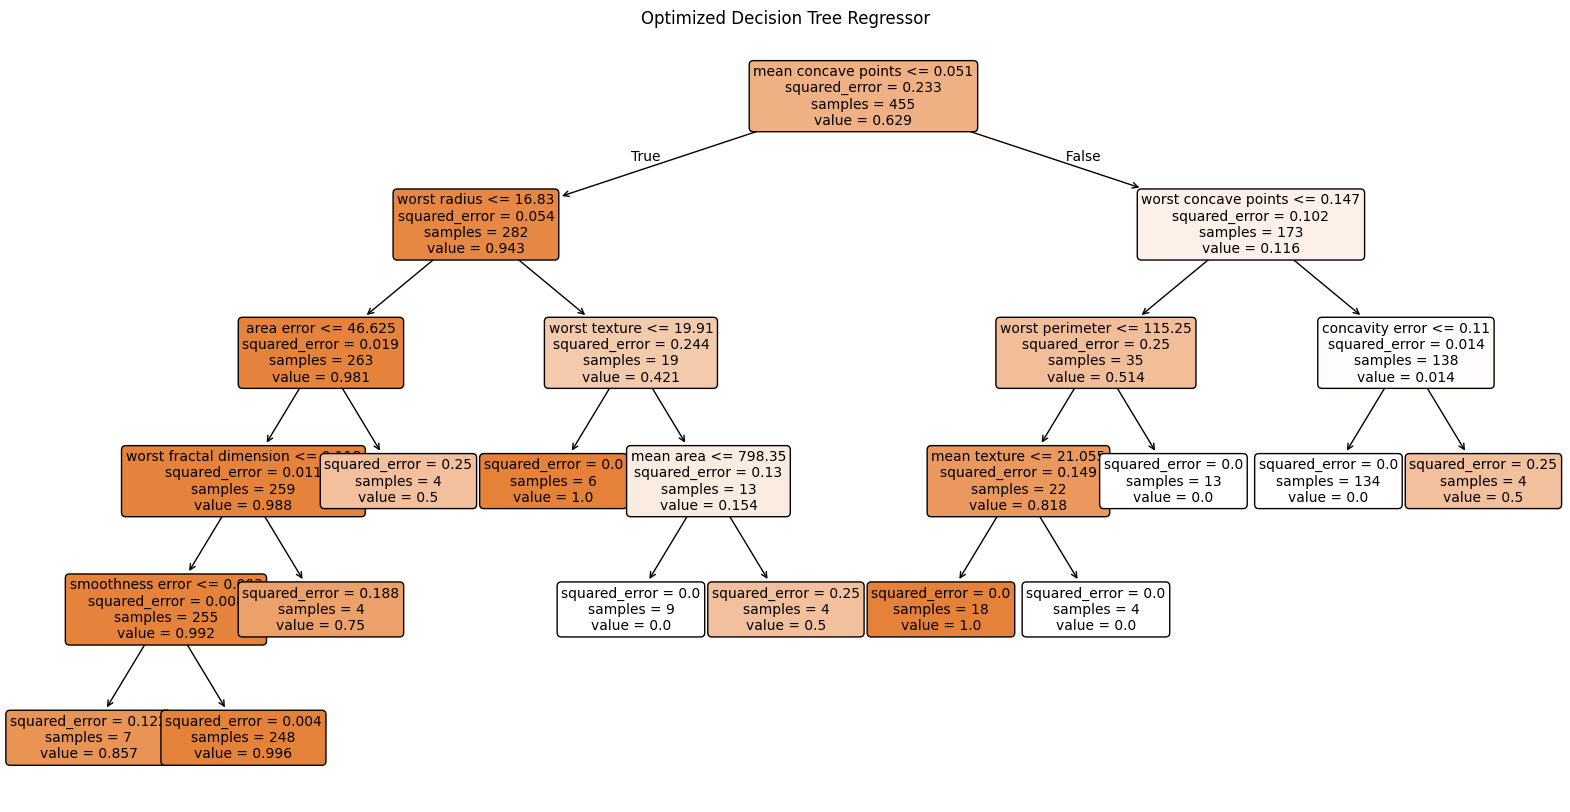

In [105]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(
    tree_reg_optimized,
    feature_names=X_train.columns,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Optimized Decision Tree Regressor")
plt.show()

## 2.  Classification – Breast‑Cancer

**Dataset**  

Key Characteristics:

- Target

    - 0 = Malignant (cancerous)

    - 1 = Benign (non-cancerous)

- Features (30 total):

    All features are numeric, derived from digitized images of breast fine needle aspirates (FNAs). Each feature describes characteristics of the cell nuclei:

    There are 10 basic measurements (e.g., radius, texture, perimeter, area, smoothness, compactness, concavity, concave points, symmetry, fractal dimension), and for each, 3 statistics are recorded:

    - .mean – average value

    - .se – standard error

    - .worst – mean of the three worst (largest) values

    Examples:

        radius_mean, texture_se, area_worst, etc.


**Hands-on Workout** 

Repeat a similar workflow for a binary classification problem.

### 2.1  Load the dataset

In [65]:
# ----- TODO: load breast‑cancer dataset into DataFrame `df_clf` ----- #

# Load the Dataset
data = load_breast_cancer(as_frame=True)
df_clf = data.frame
display(df_clf.head())

# Set labels
LABELS = {0: "Malignant", 1: "Benign"}

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


### 2.2  Train/test split
- Create `X_train`, `X_test`, `y_train`, `y_test` using an 80/20 split.
- Create `df_train` by concatenating `X_train` and `y_train`

In [48]:
# ----- TODO: split the data ----- #

# Split the data into training and testing sets
X = df_clf.drop('target', axis=1)
y = df_clf['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the split
print(f"Training features set size: {X_train.shape}")
print(f"Testing features set size: {X_test.shape}")
print(f"Training target set size: {y_train.shape}")
print(f"Testing target set size: {y_test.shape}")

Training features set size: (455, 30)
Testing features set size: (114, 30)
Training target set size: (455,)
Testing target set size: (114,)


In [49]:
# ----- TODO: create df_train ----- #

# Create Train DataFrame
df_train = pd.concat([X_train, y_train], axis=1)
df_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
68,9.029,17.33,58.79,250.5,0.10660,0.14130,0.31300,0.04375,0.2111,0.08046,...,22.65,65.50,324.7,0.14820,0.43650,1.25200,0.17500,0.4228,0.11750,1
181,21.090,26.57,142.70,1311.0,0.11410,0.28320,0.24870,0.14960,0.2395,0.07398,...,33.48,176.50,2089.0,0.14910,0.75840,0.67800,0.29030,0.4098,0.12840,0
63,9.173,13.86,59.20,260.9,0.07721,0.08751,0.05988,0.02180,0.2341,0.06963,...,19.23,65.59,310.1,0.09836,0.16780,0.13970,0.05087,0.3282,0.08490,1
248,10.650,25.22,68.01,347.0,0.09657,0.07234,0.02379,0.01615,0.1897,0.06329,...,35.19,77.98,455.7,0.14990,0.13980,0.11250,0.06136,0.3409,0.08147,1
60,10.170,14.88,64.55,311.9,0.11340,0.08061,0.01084,0.01290,0.2743,0.06960,...,17.45,69.86,368.6,0.12750,0.09866,0.02168,0.02579,0.3557,0.08020,1


### 2.3  EDA for classification data
- Visualize target class distribution
- Plot a correlation heat-map

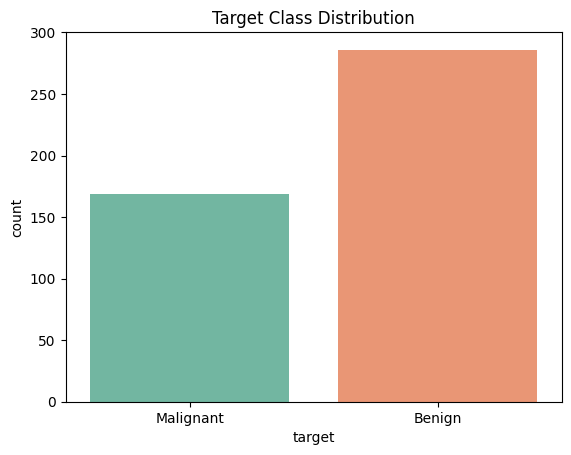

In [83]:
# ----- TODO: your EDA code ----- #

# Visualize target class distribution
sns.countplot(x='target', data=df_train, palette='Set2', hue='target', legend=False)
plt.title("Target Class Distribution")
plt.xticks(ticks=[0, 1], labels=LABELS.values())
plt.show()

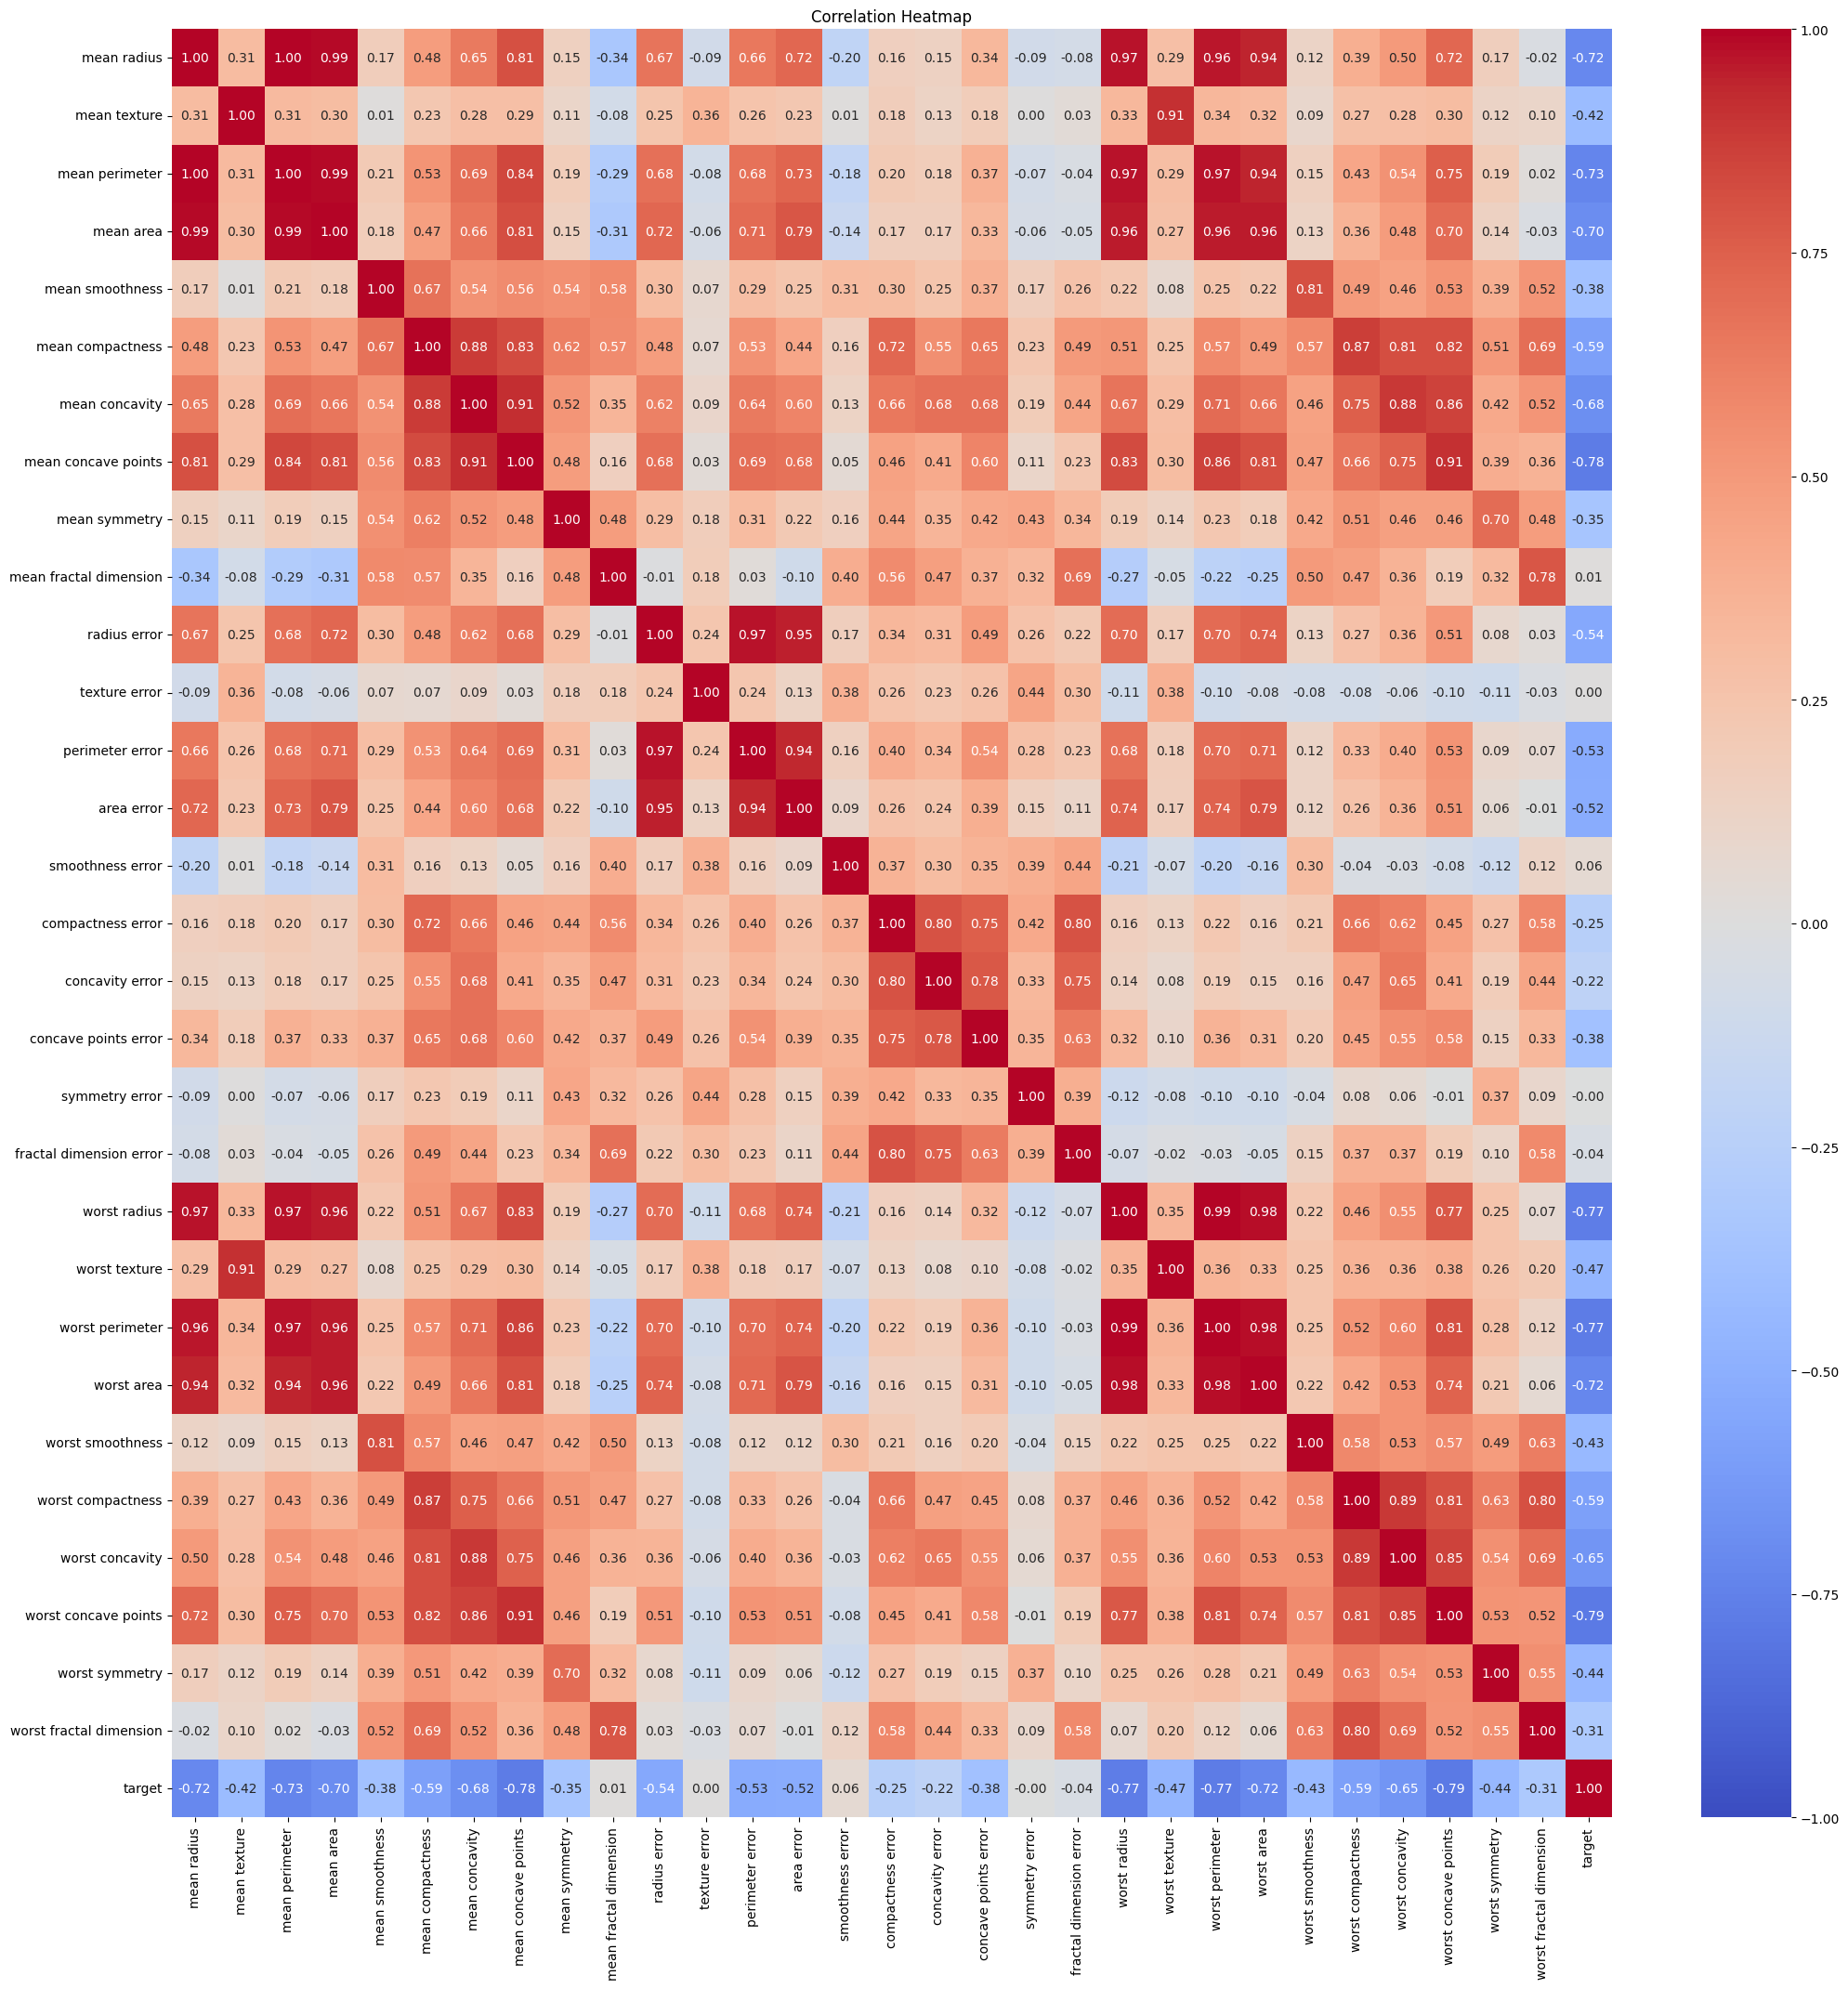

In [59]:
# Plot a correlation heat-map
plt.figure(figsize=(25, 25))
corr_matrix = df_train.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### 2.4  Pre‑processing pipeline
Use `StandardScaler` and **LogisticRegression** as a baseline.

In [61]:
# ----- TODO: pipeline with logistic regression ----- #

# Build and fit the baseline pipeline
baseline_pipeline = make_pipeline(StandardScaler(), LogisticRegression())
baseline_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

### 2.5  Evaluate baseline
Produce **confusion‑matrix**, **accuracy**, and **precision/recall** scores.

In [69]:
# 混同行列をプロットする関数
def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, labels: list, title: str, 
                            ax: matplotlib.axes.Axes) -> None:
    """
    混同行列をプロット

    Args:
        y_true (np.ndarray): 正解のクラスラベル
        y_pred (np.ndarray): 予測されたクラスラベル
        title (str): プロットのタイトル
        ax (matplotlib.axes.Axes): プロットを描画する対象の Axes
    """
    conf_mat = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(conf_mat, annot=True, cmap='coolwarm', fmt='.2f', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

Accuracy: 0.97
Precision: 0.97
Recall: 0.99
Confusion Matrix:


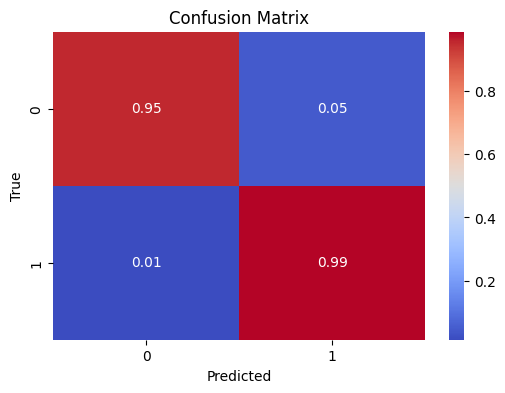

In [74]:
# ----- TODO: evaluation code ----- #

# Evaluate the baseline pipeline
y_pred = baseline_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

print(f"Confusion Matrix:")
fig, ax = plt.subplots(figsize=(6, 4))
plot_confusion_matrix(y_test, y_pred, LABELS, "Confusion Matrix", ax)

### 2.6  Random‑Forest Classifier experiment

Accuracy: 0.96
Precision: 0.96
Recall: 0.99
Confusion Matrix:


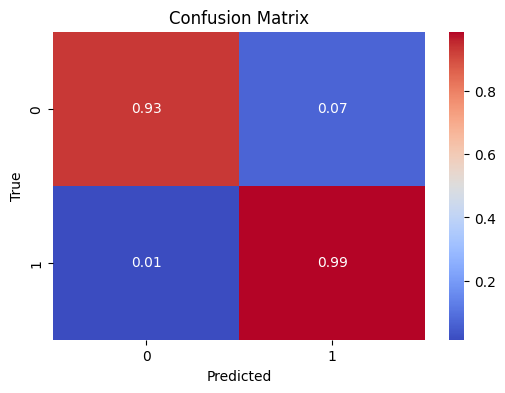

In [76]:
# ----- TODO: RandomForest pipeline & evaluation ----- #

# Build and fit the RandomForest pipeline
rf_pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))
rf_pipeline.fit(X_train, y_train)

# Evaluate the RandomForest pipeline
y_pred = rf_pipeline.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}")

print(f"Confusion Matrix:")
fig, ax = plt.subplots(figsize=(6, 4))
plot_confusion_matrix(y_test, y_pred, LABELS, "Confusion Matrix", ax)

### 2.7  Hyper‑parameter tuning (Randomized Search)
Tune `n_estimators`, `max_depth`, and `max_features`.

In [82]:
# ----- TODO: RandomizedSearchCV for RandomForest ----- #

# Build and fit the RandomForest pipeline
rf_pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))

# Correct parameter grid for auto-named step
param_dist = {
    'randomforestclassifier__n_estimators': [50, 100, 200],
    'randomforestclassifier__max_depth': [None, 5, 10],
    'randomforestclassifier__max_features': ['sqrt', 'log2', None]
}

# Randomized search
random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist,
    n_iter=5,
    cv=3,
    scoring='accuracy',
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Params:", random_search.best_params_)
print(f"Best CV Accuracy: {random_search.best_score_:.3f}")

Best Params: {'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 10}
Best CV Accuracy: 0.965


## 3. Clustering & PCA Visualization - Iris
In this block, we will apply k-means clustering to a real dataset, decide the number of clusters, and visualize the results using PCA.

### 3.1 Load the dataset

In [98]:
# ----- TODO: load the iris dataset into a DataFrame `df_iris` ----- #

# Load the Dataset
data = load_iris(as_frame=True)
df_iris = data.frame
display(df_iris.head())

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### 3.2 Preprocessing & Scaling
- Seperate features and target
- Scale the feature values with StandardScaler

In [86]:
# ----- TODO: preprocess the data ----- #

# Seperate features and target
X = df_iris.drop('target', axis=1)
y_true = df_iris['target']

# Scale the feature values with StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 3.3 Silhouette Score - Evaluating cluster quality
- Compute the silhouette score for k = 2 to 10
- Visualize scores and determine the best k

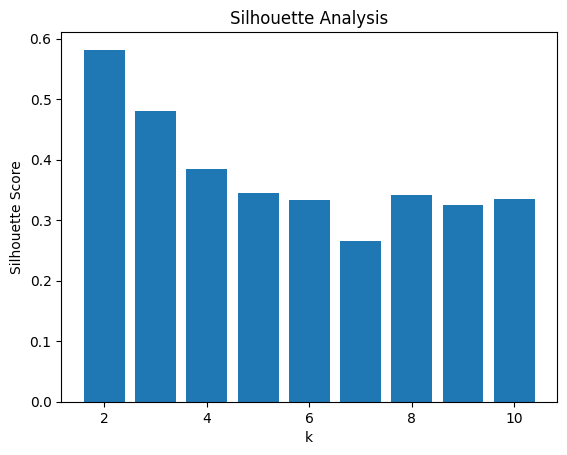

Best k by silhouette: 2


In [89]:
# ----- TODO: silhouette score ----- #

# Compute the silhouette score for k = 2 to 10
sil_scores = []

for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X_scaled)
    sil = silhouette_score(X_scaled, km.labels_)
    sil_scores.append(sil)

plt.bar(range(2, 11), sil_scores)
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.show()

best_k = 2 + np.argmax(sil_scores)
print("Best k by silhouette:", best_k)

### 3.4 Train k-means and visualize clusters with PCA
- Train k-means with the selected k
- Use PCA to project data to 2D
- Plot the clustered points 

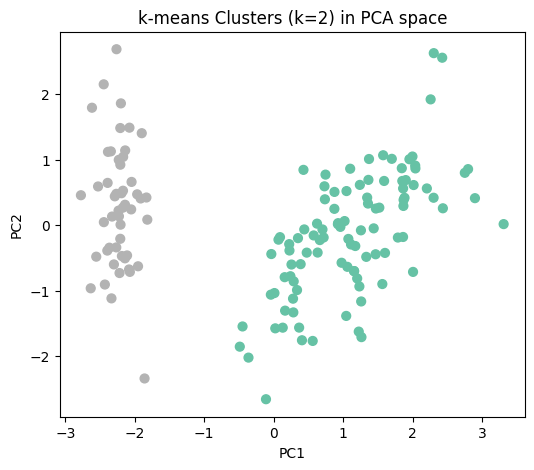

In [95]:
# ----- TODO: train k-means and visualize clusters with PCA ----- #

# Train k-means with the selected k
k = best_k
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
cluster_labels = kmeans.fit_predict(X_scaled)

# Use PCA to project data to 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
X_pca = np.asarray(X_pca)

# Plot the clustered points
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap="Set2", s=40)
plt.title(f"k-means Clusters (k={k}) in PCA space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### 3.5 Compare with ground-truth labels
- Create a crosstab of predicted clusters vs. true species
- Visualize the correspondence using a heatmap

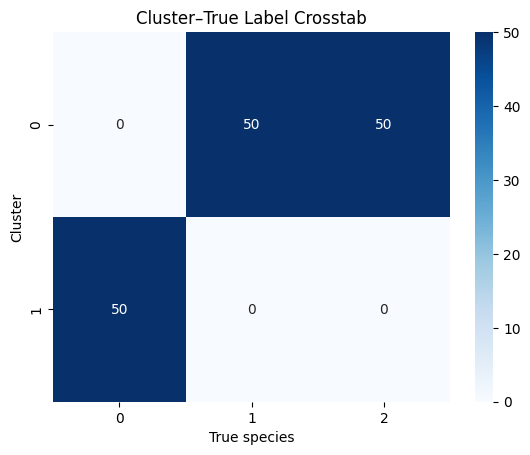

In [96]:
# ----- TODO: compare with ground-truth labels ----- #

# Create a crosstab of predicted clusters vs. true species
ct = pd.crosstab(cluster_labels, y_true, rownames=["Cluster"], colnames=["True species"])
sns.heatmap(ct, annot=True, fmt="d", cmap="Blues")
plt.title("Cluster–True Label Crosstab")
plt.show()

---

### 🎉 Congratulations — you’ve completed the exercises!
If you still have time:
- experiment with another dataset of your choice
- swap models (e.g., try `GradientBoostingRegressor` / `LGBMClassifier`)
- create feature‑importance plots and interpret them

*Happy coding!*